In [1]:
#!unzip ./dataset/CelebAMask-HQ21000.zip

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input,MaxPooling2D,Conv2D,concatenate,Activation,GlobalMaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.layers import UpSampling2D,Cropping2D,Conv2DTranspose,ZeroPadding2D,Lambda,Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import numpy as np
import matplotlib.pyplot as plt
from functools import partial 
from tensorflow.keras.applications import ResNet50
from tqdm import tqdm

In [2]:
image_size = 512  
batch_size = 4

# <span style='color:blue'>訓練資料前處理，包含normalize 及 label 處理等...</span>

In [3]:
def normalize(image):
    '''
        normalizing the images to [-1, 1]
    '''
    image = tf.cast(image, tf.float32)
    image = image/255.0
    return image

def preprocess_image(file_path, target_size=256,nclass=6):
    
    images = tf.io.read_file(file_path)
    images = tf.image.decode_jpeg(images, channels=3)
    images = tf.image.resize(images, (target_size, target_size),
                           method='nearest', antialias=True)
    images = normalize(images)
    
    mask_path = tf.strings.regex_replace(file_path, "jpg", "png")
    mask_path = tf.strings.regex_replace(mask_path, "img", "mask")
    
    mask_img = tf.io.read_file(mask_path)
    
    mask_img = tf.image.decode_png(mask_img, channels=1)
    mask = tf.cast(mask_img,dtype=tf.float32)
    mask = tf.image.resize(mask, (target_size, target_size),
                           method='nearest') 
    
    return images,mask

In [4]:
def pre_valdata(file_path,target_size):
    images = tf.io.read_file(file_path)
    images = tf.image.decode_jpeg(images, channels=3)
    images = tf.image.resize(images, (target_size, target_size),
                           method='nearest', antialias=True)
    images = normalize(images)
    
    return images

In [5]:
path = './CelebAMask-HQ21000/train/img/0.jpg'
a,b=preprocess_image(path,image_size)
print(a.shape)
print(b.shape)

(512, 512, 3)
(512, 512, 1)


# <span style='color:blue'>設定train data </span>

In [6]:
DATA_BASE_DIR = "./CelebAMask-HQ21000/train/img"
list_ds = tf.data.Dataset.list_files(DATA_BASE_DIR + '/*')

for f in list_ds.take(5):
    print(f.numpy())
preprocess_function = partial(preprocess_image, target_size=image_size)
train_data = list_ds.map(preprocess_function).shuffle(100).batch(batch_size)

b'.\\CelebAMask-HQ21000\\train\\img\\10551.jpg'
b'.\\CelebAMask-HQ21000\\train\\img\\15062.jpg'
b'.\\CelebAMask-HQ21000\\train\\img\\7392.jpg'
b'.\\CelebAMask-HQ21000\\train\\img\\4870.jpg'
b'.\\CelebAMask-HQ21000\\train\\img\\2644.jpg'


## 可視化 - 隨機取出一張train data 的image 及label  

(4, 512, 512, 3)
(512, 512)


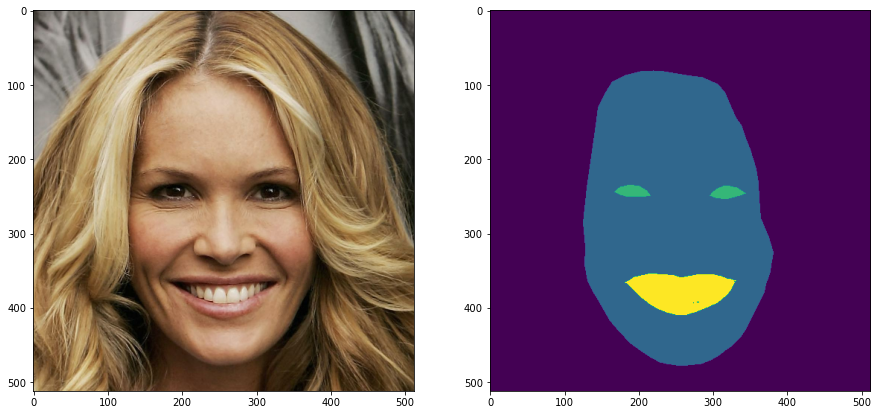

In [7]:
for img,iml in train_data.take(1):
    print(img.shape)
    print(iml.numpy()[0,:,:,0].shape)
    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.imshow(img.numpy()[0,:,:,:])
    plt.subplot(1,2,2)
    plt.imshow(iml.numpy()[0,:,:,0])
    #print(iml.numpy()[0])

# <span style='color:blue'>設定test data </span>

In [8]:
DATA_BASE_DIR = "./CelebAMask-HQ21000/test/img"
list_ds = tf.data.Dataset.list_files(DATA_BASE_DIR + '/*')

for f in list_ds.take(5):
    print(f.numpy())
    
preprocess_function = partial(preprocess_image, target_size=image_size)
test_data = list_ds.map(preprocess_function).shuffle(100).batch(batch_size)

b'.\\CelebAMask-HQ21000\\test\\img\\26447.jpg'
b'.\\CelebAMask-HQ21000\\test\\img\\28017.jpg'
b'.\\CelebAMask-HQ21000\\test\\img\\25398.jpg'
b'.\\CelebAMask-HQ21000\\test\\img\\26378.jpg'
b'.\\CelebAMask-HQ21000\\test\\img\\26605.jpg'


(4, 512, 512, 3)
(512, 512)


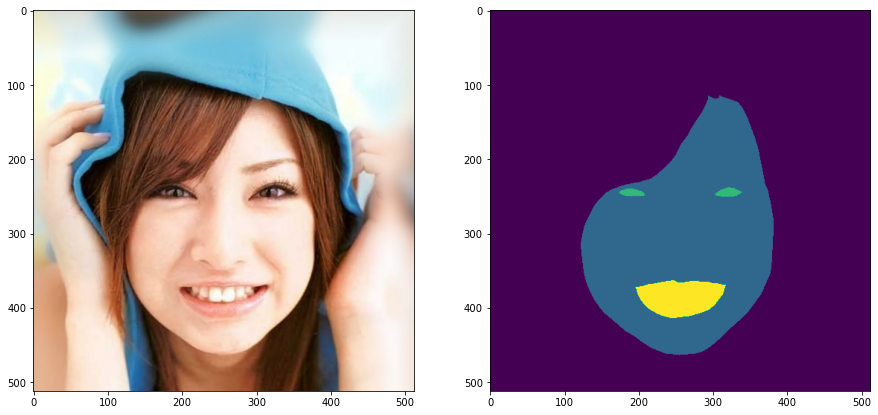

In [9]:
for img,iml in test_data.take(1):
    print(img.shape)
    print(iml.numpy()[0,:,:,0].shape)
    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.imshow(img.numpy()[0,:,:,:])
    plt.subplot(1,2,2)
    plt.imshow(iml.numpy()[0,:,:,0])
    #print(iml.numpy()[0])

# <span style='color:blue'>建立deeplab 模型</span>

In [21]:
class_num = 4 #定義輸出共4個類別，1.other 2.臉 3.眼睛 4.嘴巴

In [10]:
def se_block(inp,out_dim, ratio):
    layer_name = "se_block"
    with tf.name_scope(layer_name) :
        
        squeeze = GlobalAveragePooling2D()(inp)
        excitation = layers.Dense(out_dim / ratio)(squeeze)
        
        excitation = Activation("relu")(excitation)
        
        excitation = layers.Dense(out_dim)(excitation)
        excitation = Activation("sigmoid")(excitation)

        excitation = tf.reshape(excitation, [-1,1,1,out_dim])
        #print('inp.shape: ',inp.shape,'excitation.shape: ',excitation.shape)
        scale = inp * excitation

        return scale

In [11]:
def res2net_bottleneck(inp,init_fittles,init_stride,name):
    x = inp
    x_c = []
    y_c = []
    c_size = init_fittles//4
    for j in range(3):
        if j==0:
            x = Conv2D(init_fittles,kernel_size=(1,1),strides=init_stride,padding='same',name = name+'1_'+str(j))(x)
        else:
            x = Conv2D(init_fittles,kernel_size=(1,1),strides=1,padding='same',name = name+'1_'+str(j))(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        group_size = init_fittles//4
        for c in range(init_fittles//group_size):

            if c==0:
                y_c.append(x[:,:,:,c*c_size:(c+1)*c_size])
            elif c==1:
                x2 = x[:,:,:,c*c_size:(c+1)*c_size]
                x2 = Conv2D(group_size,kernel_size=(3,3),padding='same',name = name+f'2_x{c}_'+str(j))(x2)
                x2 = BatchNormalization()(x2)
                x2 = Activation("relu")(x2)
                y_c.append(x2)
            else:

                x_n = x[:,:,:,c*c_size:(c+1)*c_size]
                x_n = layers.add([y_c[-1],x_n])
                x_n = Conv2D(group_size,kernel_size=(3,3),padding='same',name = name+f'2_x{c}_'+str(j))(x_n)
                x_n = BatchNormalization()(x_n)
                x_n = Activation("relu")(x_n)
                y_c.append(x_n)

        x = layers.concatenate(y_c,axis=-1)
        

        x = Conv2D(init_fittles*4,kernel_size=(1,1),padding='same',name = name+'3_'+str(j))(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = se_block(x,init_fittles*4,4)
        
        if j==0:
            res_inp = Conv2D(init_fittles*4,kernel_size=(1,1),strides=init_stride,padding='same',name = name+'res_conv_'+str(j))(inp)
        else:
            res_inp = Conv2D(init_fittles*4,kernel_size=(1,1),padding='same',name = name+'res_conv_'+str(j))(inp)
        out = layers.add([res_inp,x],name=name+'out_'+str(j))
        x = out
        inp = x
    
    return out

In [12]:
def res2net(inp):
    x = layers.ZeroPadding2D()(inp)
    x = Conv2D(64,kernel_size=(7,7),strides=2,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=3,strides=2)(x)
    init_fittles = 64
    for i in ['conv2_','conv3_','conv4_']:
        if i=='conv2_':
            x = res2net_bottleneck(x,init_fittles,1,i)
        else:
            x = res2net_bottleneck(x,init_fittles,2,i)
        init_fittles*=2
        
    model = keras.models.Model(inp,x)
    
    #model.summary()
    
    return model

In [13]:
def ASPP(inp,filters=256):
    
    conv1=Conv2D(filters,kernel_size=(1,1),padding='same')(inp)
    conv1=BatchNormalization()(conv1)
    conv1=Activation("relu")(conv1)
    
    conv2=Conv2D(filters,kernel_size=(3,3),padding='same',dilation_rate=6)(inp)
    conv2=BatchNormalization()(conv2)
    conv2=Activation("relu")(conv2)
    
    conv3=Conv2D(filters,kernel_size=(3,3),padding='same',dilation_rate=12)(inp)
    conv3=BatchNormalization()(conv3)
    conv3=Activation("relu")(conv3)
    
    conv4=Conv2D(filters,kernel_size=(3,3),padding='same',dilation_rate=18)(inp)
    conv4=BatchNormalization()(conv4)
    conv4=Activation("relu")(conv4)
    
    pool1 = keras.layers.Lambda(lambda  x: tf.math.reduce_mean(x, [1,2], keepdims = True))(inp);
    pool1=Conv2D(filters,kernel_size=(1,1),padding='same',name='pool_conv1')(pool1)
    pool1=BatchNormalization()(pool1)
    pool1=Activation("relu")(pool1)
    pool1 = tf.keras.layers.Lambda(lambda x: tf.image.resize(x[0], (tf.shape(x[1])[1], tf.shape(x[1])[2]), 
                                                            method = tf.image.ResizeMethod.BILINEAR))([pool1, inp]);
    
    results = concatenate([pool1, conv1, conv2, conv3, conv4],axis = -1);
    #results = concatenate([conv1, conv2, conv3, conv4],axis = -1);
    results = Conv2D(filters, kernel_size = (1,1), padding = 'same', kernel_initializer = keras.initializers.he_normal(), 
                     use_bias = False)(results);
    results = BatchNormalization()(results);
    results = Activation("relu")(results);
    
    return results;
    
    
    


def deeplabv3_plus(shape):
    inp=Input(shape)
    
    encoder=res2net(inp)
    low_level_feature=encoder.get_layer("conv2_out_2").output
    high_level_feature=encoder.get_layer("conv4_out_2").output
    

    encoder.summary()
    aspp=ASPP(high_level_feature)
    
    high=UpSampling2D((4,4))(aspp)
    low=Conv2D(48,kernel_size=(1,1),padding='same')(low_level_feature)
    low=BatchNormalization()(low)
    low=Activation("relu")(low)
    x=concatenate([low,high],axis=-1)
    
    x=Conv2D(256,kernel_size=(3,3),padding='same')(x)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    
    x=Conv2D(128,kernel_size=(3,3),padding='same')(x)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    
    x=UpSampling2D((4,4))(x)
    
    x=Conv2D(class_num,kernel_size=(1,1),padding='same')(x)
    x=BatchNormalization()(x)
    x=Activation("softmax")(x)
    
    model=Model(inputs = inp, outputs = x);
    model.summary()
    return model

## 產生model

In [ ]:
model = deeplabv3_plus((image_size,image_size,3))

## 訓練model

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 514, 514, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 257, 257, 64  9472        ['zero_padding2d_1[0][0]']       
                                )                                                           

 conv2_3_0 (Conv2D)             (None, 128, 128, 25  16640       ['concatenate_11[0][0]']         
                                6)                                                                
                                                                                                  
 batch_normalization_61 (BatchN  (None, 128, 128, 25  1024       ['conv2_3_0[0][0]']              
 ormalization)                  6)                                                                
                                                                                                  
 activation_79 (Activation)     (None, 128, 128, 25  0           ['batch_normalization_61[0][0]'] 
                                6)                                                                
                                                                                                  
 global_average_pooling2d_9 (Gl  (None, 256)         0           ['activation_79[0][0]']          
 obalAvera

 licingOpLambda)                )                                                                 
                                                                                                  
 activation_85 (Activation)     (None, 128, 128, 16  0           ['batch_normalization_65[0][0]'] 
                                )                                                                 
                                                                                                  
 concatenate_12 (Concatenate)   (None, 128, 128, 12  0           ['tf.__operators__.getitem_36[0][
                                8)                               0]',                             
                                                                  'activation_76[0][0]',          
                                                                  'activation_77[0][0]',          
                                                                  'activation_78[0][0]',          
          

                                )                                                                 
                                                                                                  
 tf.__operators__.getitem_47 (S  (None, 128, 128, 16  0          ['activation_89[0][0]']          
 licingOpLambda)                )                                                                 
                                                                                                  
 add_23 (Add)                   (None, 128, 128, 16  0           ['activation_91[0][0]',          
                                )                                 'tf.__operators__.getitem_47[0][
                                                                 0]']                             
                                                                                                  
 conv2_2_x3_2 (Conv2D)          (None, 128, 128, 16  2320        ['add_23[0][0]']                 
          

 ormalization)                                                                                    
                                                                                                  
 activation_97 (Activation)     (None, 64, 64, 32)   0           ['batch_normalization_73[0][0]'] 
                                                                                                  
 tf.__operators__.getitem_50 (S  (None, 64, 64, 32)  0           ['activation_96[0][0]']          
 licingOpLambda)                                                                                  
                                                                                                  
 add_24 (Add)                   (None, 64, 64, 32)   0           ['activation_97[0][0]',          
                                                                  'tf.__operators__.getitem_50[0][
                                                                 0]']                             
          

 batch_normalization_78 (BatchN  (None, 64, 64, 32)  128         ['conv3_2_x1_1[0][0]']           
 ormalization)                                                                                    
                                                                                                  
 activation_104 (Activation)    (None, 64, 64, 32)   0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 tf.__operators__.getitem_54 (S  (None, 64, 64, 32)  0           ['activation_103[0][0]']         
 licingOpLambda)                                                                                  
                                                                                                  
 add_26 (Add)                   (None, 64, 64, 32)   0           ['activation_104[0][0]',         
                                                                  'tf.__operators__.getitem_54[0][
          

 tf.__operators__.getitem_57 (S  (None, 64, 64, 32)  0           ['activation_110[0][0]']         
 licingOpLambda)                                                                                  
                                                                                                  
 conv3_2_x1_2 (Conv2D)          (None, 64, 64, 32)   9248        ['tf.__operators__.getitem_57[0][
                                                                 0]']                             
                                                                                                  
 batch_normalization_83 (BatchN  (None, 64, 64, 32)  128         ['conv3_2_x1_2[0][0]']           
 ormalization)                                                                                    
                                                                                                  
 activation_111 (Activation)    (None, 64, 64, 32)   0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 conv3_out_2 (Add)              (None, 64, 64, 512)  0           ['conv3_res_conv_2[0][0]',       
                                                                  'tf.math.multiply_14[0][0]']    
                                                                                                  
 conv4_1_0 (Conv2D)             (None, 32, 32, 256)  131328      ['conv3_out_2[0][0]']            
                                                                                                  
 batch_normalization_87 (BatchN  (None, 32, 32, 256)  1024       ['conv4_1_0[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_117 (Activation)    (None, 32, 32, 256)  0           ['batch_normalization_87[0][0]'] 
          

                                )                                                                 
                                                                                                  
 tf.math.multiply_15 (TFOpLambd  (None, 32, 32, 1024  0          ['activation_121[0][0]',         
 a)                             )                                 'tf.reshape_15[0][0]']          
                                                                                                  
 conv4_out_0 (Add)              (None, 32, 32, 1024  0           ['conv4_res_conv_0[0][0]',       
                                )                                 'tf.math.multiply_15[0][0]']    
                                                                                                  
 conv4_1_1 (Conv2D)             (None, 32, 32, 256)  262400      ['conv4_out_0[0][0]']            
                                                                                                  
 batch_nor

 activation_129 (Activation)    (None, 256)          0           ['dense_32[0][0]']               
                                                                                                  
 dense_33 (Dense)               (None, 1024)         263168      ['activation_129[0][0]']         
                                                                                                  
 activation_130 (Activation)    (None, 1024)         0           ['dense_33[0][0]']               
                                                                                                  
 tf.reshape_16 (TFOpLambda)     (None, 1, 1, 1024)   0           ['activation_130[0][0]']         
                                                                                                  
 conv4_res_conv_1 (Conv2D)      (None, 32, 32, 1024  1049600     ['conv4_out_0[0][0]']            
                                )                                                                 
          

                                )                                                                 
                                                                                                  
 batch_normalization_101 (Batch  (None, 32, 32, 1024  4096       ['conv4_3_2[0][0]']              
 Normalization)                 )                                                                 
                                                                                                  
 activation_135 (Activation)    (None, 32, 32, 1024  0           ['batch_normalization_101[0][0]']
                                )                                                                 
                                                                                                  
 global_average_pooling2d_17 (G  (None, 1024)        0           ['activation_135[0][0]']         
 lobalAveragePooling2D)                                                                           
          

 conv2_2_x2_0 (Conv2D)          (None, 128, 128, 16  2320        ['add_18[0][0]']                 
                                )                                                                 
                                                                                                  
 batch_normalization_59 (BatchN  (None, 128, 128, 16  64         ['conv2_2_x2_0[0][0]']           
 ormalization)                  )                                                                 
                                                                                                  
 activation_77 (Activation)     (None, 128, 128, 16  0           ['batch_normalization_59[0][0]'] 
                                )                                                                 
                                                                                                  
 tf.__operators__.getitem_39 (S  (None, 128, 128, 16  0          ['activation_75[0][0]']          
 licingOpL

                                                                                                  
 activation_83 (Activation)     (None, 128, 128, 16  0           ['batch_normalization_63[0][0]'] 
                                )                                                                 
                                                                                                  
 tf.__operators__.getitem_42 (S  (None, 128, 128, 16  0          ['activation_82[0][0]']          
 licingOpLambda)                )                                                                 
                                                                                                  
 add_20 (Add)                   (None, 128, 128, 16  0           ['activation_83[0][0]',          
                                )                                 'tf.__operators__.getitem_42[0][
                                                                 0]']                             
          

                                )                                                                 
                                                                                                  
 batch_normalization_67 (BatchN  (None, 128, 128, 64  256        ['conv2_1_2[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_89 (Activation)     (None, 128, 128, 64  0           ['batch_normalization_67[0][0]'] 
                                )                                                                 
                                                                                                  
 tf.__operators__.getitem_45 (S  (None, 128, 128, 16  0          ['activation_89[0][0]']          
 licingOpLambda)                )                                                                 
          

 dense_22 (Dense)               (None, 64)           16448       ['global_average_pooling2d_11[0][
                                                                 0]']                             
                                                                                                  
 activation_94 (Activation)     (None, 64)           0           ['dense_22[0][0]']               
                                                                                                  
 dense_23 (Dense)               (None, 256)          16640       ['activation_94[0][0]']          
                                                                                                  
 activation_95 (Activation)     (None, 256)          0           ['dense_23[0][0]']               
                                                                                                  
 tf.reshape_11 (TFOpLambda)     (None, 1, 1, 256)    0           ['activation_95[0][0]']          
          

 lobalAveragePooling2D)                                                                           
                                                                                                  
 dense_24 (Dense)               (None, 128)          65664       ['global_average_pooling2d_12[0][
                                                                 0]']                             
                                                                                                  
 activation_101 (Activation)    (None, 128)          0           ['dense_24[0][0]']               
                                                                                                  
 dense_25 (Dense)               (None, 512)          66048       ['activation_101[0][0]']         
                                                                                                  
 activation_102 (Activation)    (None, 512)          0           ['dense_25[0][0]']               
          

 batch_normalization_81 (BatchN  (None, 64, 64, 512)  2048       ['conv3_3_1[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_107 (Activation)    (None, 64, 64, 512)  0           ['batch_normalization_81[0][0]'] 
                                                                                                  
 global_average_pooling2d_13 (G  (None, 512)         0           ['activation_107[0][0]']         
 lobalAveragePooling2D)                                                                           
                                                                                                  
 dense_26 (Dense)               (None, 128)          65664       ['global_average_pooling2d_13[0][
                                                                 0]']                             
          

                                                                  'activation_104[0][0]',         
                                                                  'activation_105[0][0]',         
                                                                  'activation_106[0][0]',         
                                                                  'tf.__operators__.getitem_56[0][
                                                                 0]',                             
                                                                  'activation_111[0][0]',         
                                                                  'activation_112[0][0]',         
                                                                  'activation_113[0][0]']         
                                                                                                  
 conv3_3_2 (Conv2D)             (None, 64, 64, 512)  197120      ['concatenate_16[0][0]']         
          

 licingOpLambda)                                                                                  
                                                                                                  
 activation_120 (Activation)    (None, 32, 32, 64)   0           ['batch_normalization_90[0][0]'] 
                                                                                                  
 concatenate_17 (Concatenate)   (None, 32, 32, 256)  0           ['tf.__operators__.getitem_60[0][
                                                                 0]',                             
                                                                  'activation_118[0][0]',         
                                                                  'activation_119[0][0]',         
                                                                  'activation_120[0][0]']         
                                                                                                  
 conv4_3_0

 batch_normalization_95 (BatchN  (None, 32, 32, 64)  256         ['conv4_2_x3_1[0][0]']           
 ormalization)                                                                                    
                                                                                                  
 tf.__operators__.getitem_64 (S  (None, 32, 32, 64)  0           ['activation_124[0][0]']         
 licingOpLambda)                                                                                  
                                                                                                  
 activation_127 (Activation)    (None, 32, 32, 64)   0           ['batch_normalization_95[0][0]'] 
                                                                                                  
 concatenate_18 (Concatenate)   (None, 32, 32, 512)  0           ['tf.__operators__.getitem_60[0][
                                                                 0]',                             
          

 tf.__operators__.getitem_71 (S  (None, 32, 32, 64)  0           ['activation_131[0][0]']         
 licingOpLambda)                                                                                  
                                                                                                  
 add_35 (Add)                   (None, 32, 32, 64)   0           ['activation_133[0][0]',         
                                                                  'tf.__operators__.getitem_71[0][
                                                                 0]']                             
                                                                                                  
 conv4_2_x3_2 (Conv2D)          (None, 32, 32, 64)   36928       ['add_35[0][0]']                 
                                                                                                  
 batch_normalization_100 (Batch  (None, 32, 32, 64)  256         ['conv4_2_x3_2[0][0]']           
 Normaliza

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_103 (Batch  (None, 32, 32, 256)  1024       ['conv2d_12[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_104 (Batch  (None, 32, 32, 256)  1024       ['conv2d_13[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_105 (Batch  (None, 32, 32, 256)  1024       ['conv2d_14[0][0]']              
 Normalization)                                                                                   
          

(512, 4)


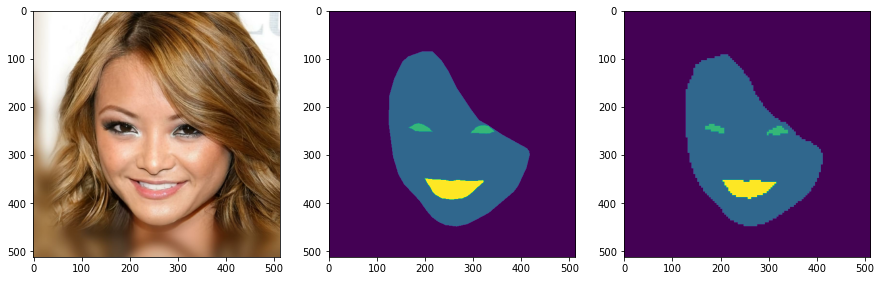

In [20]:
epochs = 1 
key="deeplabv3_plus"
initlr = 1e-3

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initlr,epochs,.96)
m = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10)
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate = initlr),
              metrics=['accuracy'])

lr_schedule = keras.callbacks.LearningRateScheduler(lr_schedule)
# checkpoint = keras.callbacks.ModelCheckpoint(filepath="output/deeplabv3_plus_model.h5", monitor='val_accuracy',verbose=1, 
#                                     save_best_only=True)


his = model.fit(train_data,verbose=1,epochs=epochs,validation_data=test_data,callbacks=[lr_schedule])
model_test(model)             

## 繪製訓練曲線

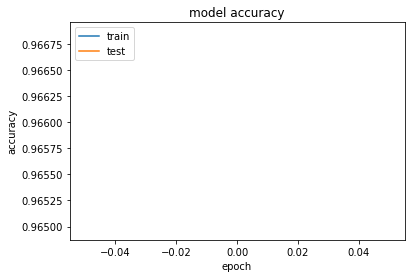

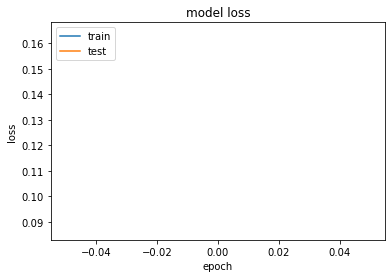

In [22]:
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()
# summarize history for loss 
plt.plot(his.history['loss']) 
plt.plot(his.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

# <span style='color:blue'>定義測試數據 及 模型測試函數</span>

## 定義miou 作為測試model 指標

In [16]:
class MyMeanIOU(tf.keras.metrics.MeanIoU):
    
    def update_state( y_true, y_pred):
        fun = tf.keras.metrics.MeanIoU(num_classes=2)
        
        return super().update_state(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1), sample_weight)

def iou(y_true, y_pred):
    temp = 0
    
    for i in range(y_true.shape[-1]):
        y = y_true[:,:,:,i]
        x = y_pred[:,:,:,i]
        y=keras.backend.flatten(y)
        x=keras.backend.flatten(x)
        intersection=keras.backend.sum(y*x)
        temp+=(intersection+1.0)/(keras.backend.sum(y)+keras.backend.sum(x)-intersection+1.0)
    return temp/y_true.shape[-1]

In [15]:
val_DIR = "./CelebAMask-HQ21000/val"
val_ds = tf.data.Dataset.list_files(val_DIR + '/*')
pre_valdata_function = partial(pre_valdata, target_size=image_size)
val_data = val_ds.map(pre_valdata_function).batch(1)
def model_test(model,test_input = val_data):

        
    for img,iml in test_data.take(1):
        print(iml.numpy()[0,:,:,0].shape)
        plt.figure(figsize=(15,10))
        plt.subplot(1,3,1)
        plt.imshow(img.numpy()[0,:,:,:])
        plt.subplot(1,3,2)
        plt.imshow(iml.numpy()[0,:,:,0])
        ans=model.predict(img)[0]
        
        miou = 0
        for c in range(4):
            m = tf.keras.metrics.MeanIoU(num_classes=2)
            aaa = iml[0,:,:,0].numpy()
            bbb = ans[:,:,c].copy()
            aaa = np.reshape(aaa,(aaa.shape)+(1,))
            bbb = np.reshape(bbb,(bbb.shape)+(1,))
            if c==0:
                aaa[aaa!=0] =1
                aaa =abs(aaa-1)
            else:          
                aaa[aaa!=c] =0
                aaa[aaa==c] =1
            bbb[bbb>=0.5]=1
            bbb[bbb<0.5]=0
            m.update_state(bbb, aaa)
            miou += m.result().numpy()
            print(str(c) + '_iou : ',m.result().numpy())
        print(f'miou : {miou/4}')
        
        im_base = np.zeros((image_size,image_size))
        #print(ans)
        for i in range(image_size):
            for j in range(image_size):
                temp = ans[i,j]
                #print(temp)

                pri_cls=np.where(temp == np.max(temp))
                #print(pri_cls[0][0])
                im_base[i,j]=pri_cls[0][0]
        print(ans[0].shape)
        plt.subplot(1,3,3)
        plt.imshow(im_base)


(512, 512)
0_iou :  0.8830191
1_iou :  0.82408154
2_iou :  0.49754333
3_iou :  0.5499438
miou : 0.6886469423770905
(512, 4)


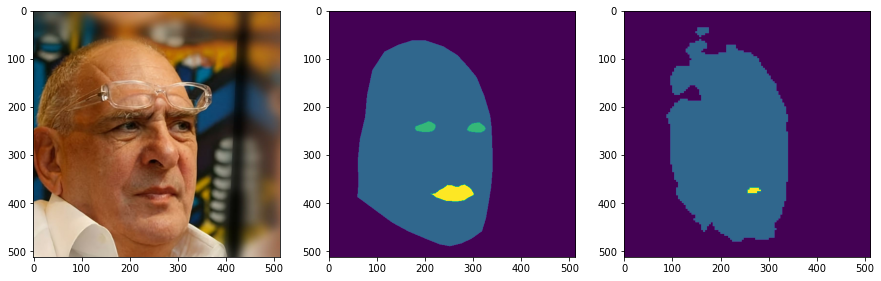

In [19]:
model_test(model)   

# 計算整個val dataset的總miou

In [37]:
def test_miou(model):
    miou = 0
    val_size = 3000
    val_DIR = "./CelebAMask-HQ21000/val"
    val_ds = tf.data.Dataset.list_files(val_DIR + '/*')
    pre_valdata_function = partial(pre_valdata, target_size=image_size)
    val_data = val_ds.map(pre_valdata_function).batch(1)
    m = tf.keras.metrics.MeanIoU(num_classes=2)
    d = {'miou':miou}
    cal=1

    for i in tqdm(range(val_size)):
        for img,iml in test_data.take(1): 
            local_miou = 0
            
            ans=model.predict(img)[0]

            for c in range(4):
                
                aaa = iml[0,:,:,0].numpy()
                bbb = ans[:,:,c].copy()
                aaa = np.reshape(aaa,(aaa.shape)+(1,))
                bbb = np.reshape(bbb,(bbb.shape)+(1,))
                if c==0:
                    aaa[aaa!=0] =1
                    aaa =abs(aaa-1)
                else:          
                    aaa[aaa!=c] =0
                    aaa[aaa==c] =1
                bbb[bbb>=0.5]=1
                bbb[bbb<0.5]=0
                m.update_state(bbb, aaa)
                local_miou += m.result().numpy()
        local_miou/=4
        miou+=local_miou
    #print(f'miou : {miou/val_size}')
    
    return miou/val_size
        

In [38]:
miou = test_miou(model)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [28:28<00:00,  1.76it/s]


In [39]:
miou

0.9542655043353637

In [31]:
#保存模型
#model.save("outputs/deeplabv3_plus_resnet.h5")